In [49]:
import numpy as np
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import Dataset, DataLoader
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

In [54]:
# PARAMS
N_VOCABS = 10_000
BATCH_SIZE = 64
WORD_MAX_LEN = 700

first_time = True
colab = False

In [55]:
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

    TOKENIZER_PICKLE_PATH = '/content/drive/MyDrive/AITest/tokenizer.pickle'
    MODEL_PTH_PATH = '/content/drive/MyDrive/AITest/urgency_classifier.pth'
    DATA_PATH = '/content/drive/MyDrive/AITest/data.xlsx'
else:
    TOKENIZER_PICKLE_PATH = './tokenizer.pickle'
    MODEL_PTH_PATH = './urgency_classifier.pth'
    DATA_PATH = './data.xlsx'

In [56]:
df = pd.read_excel(DATA_PATH)

df = df.dropna(subset=['Text', 'Urgency(1-7)'])
df['Urgency'] = df['Urgency(1-7)'].apply(lambda x: 1 if x >=4 else 0)
x = df['Text'].values.astype(str)
y = df['Urgency'].values.astype(np.float32)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

mean_size = np.mean([len(data) for data in x_train])
std_size = np.std([len(data) for data in x_train])
print("mean_size:", mean_size)
print("std_size:", std_size)

tokenizer = Tokenizer(num_words=N_VOCABS)

if first_time:
    tokenizer.fit_on_texts(x_train)
    with open(TOKENIZER_PICKLE_PATH, 'wb') as f:
        pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(TOKENIZER_PICKLE_PATH, 'rb') as f:
        tokenizer = pickle.load(f)

X_train_seq = tokenizer.texts_to_sequences(x_train)
X_test_seq = tokenizer.texts_to_sequences(x_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=WORD_MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=WORD_MAX_LEN, padding='post')


mean_size: 360.58204543535174
std_size: 393.7883653838288


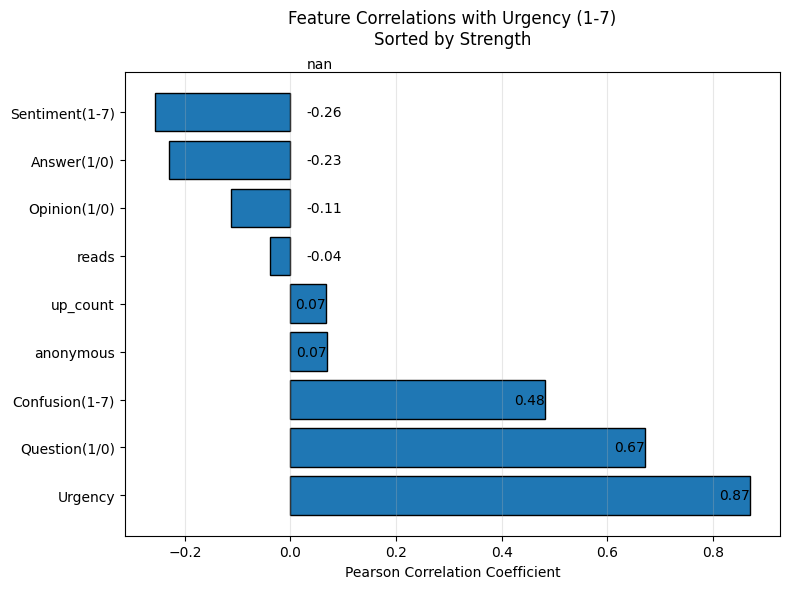

In [61]:
# Calculate correlations
num_df = df.select_dtypes(include=[np.number])
corr_series = num_df.corr()['Urgency(1-7)'].drop('Urgency(1-7)').sort_values(ascending=False)

# Create plot
plt.figure(figsize=(8, 6))  # Vertical format for better feature-name readability

# Create horizontal bars with color mapping
bars = plt.barh(
    corr_series.index[::-1],  # Reverse for descending order (highest at top)
    corr_series.values[::-1],
    edgecolor='black'
)

# Annotate values
for bar in bars:
    width = bar.get_width()
    plt.text(width if width > 0 else 0.03,  # Position negative values on left
             bar.get_y() + bar.get_height()/2,
             f'{width:.2f}',
             va='center', ha='right' if width > 0 else 'left',
             color='black')

plt.xlabel('Pearson Correlation Coefficient')
plt.title('Feature Correlations with Urgency (1-7)\nSorted by Strength', pad=20)
plt.gca().invert_yaxis()  # Show highest correlation at top
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

In [11]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]


train_dataset = TextDataset(X_train_pad, y_train)
test_dataset = TextDataset(X_train_pad, y_train)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

class UrgencyClassifier(nn.Module):
    def __init__(self, vocab_size=N_VOCABS+1, embed_dim=128, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, 1)  # *2 for bidirectional
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        hidden = self.dropout(hidden)
        return self.fc(hidden).squeeze()


model = UrgencyClassifier()
model.load_state_dict(torch.load(MODEL_PTH_PATH, weights_only=True))
model.to(device)

UrgencyClassifier(
  (embedding): Embedding(10001, 128, padding_idx=0)
  (lstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
save_freq = 100


epochs = 100
i = 0
for epoch in range(epochs):
    model.train()
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        i += 1
        if i == save_freq:
            model.to(torch.device('cpu'))
            torch.save(model.state_dict(), MODEL_PTH_PATH)
            model.to(device)
            print(f'saving... loss: {loss.item()}')
            i = 0

    print(f'Epoch {epoch+1}, loss: {loss.item()}')

In [39]:
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for texts, labels in loader:
            texts = texts.to(device)
            outputs = torch.sigmoid(model(texts))
            preds = torch.round(outputs).cpu().numpy().flatten()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy().flatten())

    # overall accuracy
    acc = accuracy_score(all_labels, all_preds)
    # weighted F1 (accounts for class imbalance)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    # urgent-class F1 (precision–recall balance for the positive label)
    f1_urgent  = f1_score(all_labels, all_preds, pos_label=1, average='binary')

    # confusion matrix: [[TN, FP],
    #                    [FN, TP]]
    cm = confusion_matrix(all_labels, all_preds)

    return acc, f1_weighted, f1_urgent, cm

# Usage
test_acc, test_f1_w, test_f1_u, test_cm = evaluate(model, test_loader)
print(f'Accuracy:          {test_acc:.4f}')
print(f'Weighted F1:       {test_f1_w:.4f}')
print(f'Urgent-class F1:   {test_f1_u:.4f}')
print('Confusion Matrix:')
print(test_cm)


Accuracy:          0.9679
Weighted F1:       0.9678
Urgent-class F1:   0.9254
Confusion Matrix:
[[18205   343]
 [  417  4717]]


In [41]:
tn, fp, fn, tp = test_cm.ravel()  # if cm is an np.array; otherwise unpack manually

precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0

precision, recall


(0.9322134387351778, 0.9187767822360733)

In [ ]:
urgent_txt = """
Subject: Critical Database Outage

At 04:17 AM UTC, our primary customer database encountered a fatal error causing service interruptions for all users. Immediate action is required to restore full functionality:

1. Investigate and restart the database cluster nodes.  
2. Apply the latest hotfix (v3.4.2) to prevent recurrence.  
3. Notify the incident response team and stakeholders.  

Please treat this as P1 and confirm when the systems are back online.
"""

txt = urgent_txt

txt_seq = tokenizer.texts_to_sequences([txt])
txt_seq = pad_sequences(txt_seq, maxlen=WORD_MAX_LEN, padding='post')

txt_seq = torch.tensor(txt_seq)
torch.sigmoid(model(txt_seq)

tensor(-14.1857, grad_fn=<SqueezeBackward0>)